<a href="https://colab.research.google.com/github/Evanaxander/zerotier/blob/main/build_zerotier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First, an Introduction

A L2 VPN implemented similar to Zerotier or a Virtual Switch.

It simulates the behavior of a physical switch, providing Ethernet frame exchange services for devices connected to the switch's ports.

The difference is that the ports of this virtual switch can be connected to devices all over the world through the Internet, making them appear to be in the same local area network for the operating system

# Background Knowledge

**What is Network Switch?**

A network switch is networking hardware that connects devices on a computer network by using packet switching to receive and forward data to the destination device.

A network switch is a multiport network bridge that uses MAC addresses to forward data at the data link layer (layer 2) of the OSI model. Some switches can also forward data at the network layer (layer 3) by additionally incorporating routing functionality. Such switches are commonly known as layer-3 switches or multilayer switches.

In this project, we focues on layer-2 switchs, which recognize and forward Ethernet frames. When forwarding packets, switches use a forwarding table to look up the port corresponding to the destination address.

In a switch, the forwarding table is generally called the MAC address table. This table maintains the MAC addresses known in the local network and their corresponding ports. When a switch receives a Ethernet frame, it looks up the port corresponding to the destination MAC address in the forwarding table, and forwards the data frame only to that port, thereby achieving data forwarding within the local area network. If the destination MAC address is not in the table, the switch forwards the Ethernet frame to all ports except the source port so that the target device can respond and update the forwarding table.

In this project, we will write a program called VSwitch as a virtual switch to achieve Ethernet frame exchange function.

**Virtual Network Device: TAP**

TAP is a type of virtual network device that can simulate a physical network interface, allowing operating systems and applications to use it like a physical interface. TAP devices are commonly used to create virtual private network (VPN) connections between different computers for secure data transmission over public networks.

The TAP device is implemented in the operating system kernel. It looks like a regular network interface and can be used in applications like a regular physical network card. When packets are sent through the TAP device, they are passed to the TUN/TAP driver in the kernel, which passes the packets to the application. The application can process the packets and pass them to other devices or networks. Similarly, when applications send packets, they are passed to the TUN/TAP driver, which forwards them to the specified target device or network.

In this project, the TAP device is used to connect client computers and the virtual switch, enabling packet forwarding between client computers and the virtual switch.

# System Architecture



*   Composed of a server (VSwitch) and several clients (VPorts)

*  The server (VSwitch) simulates the behavior of a physical network switch, providing Ethernet frame exchange service for each computers connected to the VSwitch by VPorts.
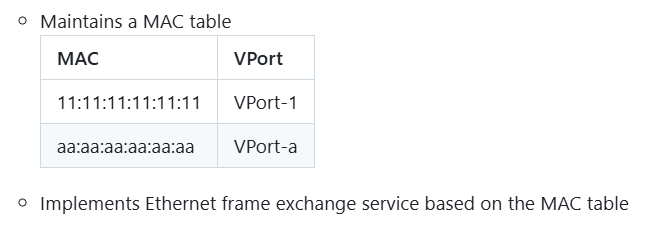

*  The client (VPort) simulates the behavior of a physical switch port, responsible for relaying Ethernet frames between the switch and the computer.

*   VPort has two ends:


1.   One end is connected to a computer('s linux kernel) through TAP device.
2.   The other end is connected to the VSwitch through UDP socket.





Responsible for relaying packets between the computer('s linux kernel) and the VSwitch.

Computer's Linux Kernel <==[TAP]==> (Ethernet Frame) <==[UDP]==> VServer

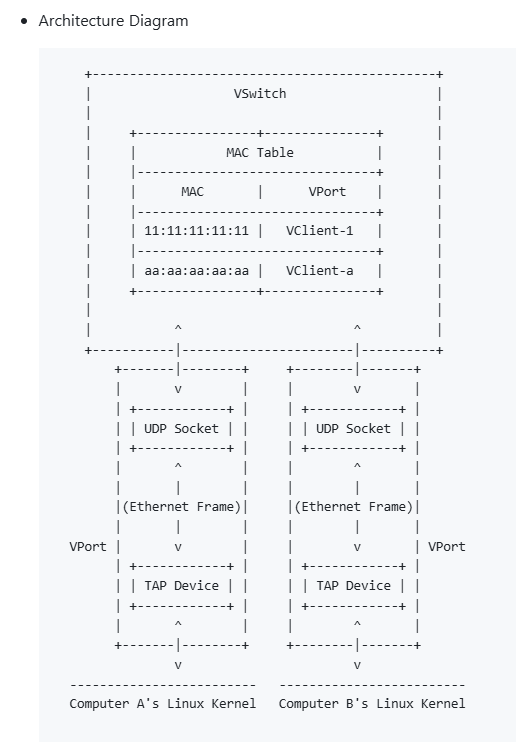

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import socket
import sys

# parse parameters
server_port = None
if len(sys.argv) != 2:
  print("Usage: python3 vswitch.py {VSWITCH_PORT}")
  # Instead of exiting, assign a default port if none is provided.
  server_port = 5000  # Example default port
  print(f"Using default port: {server_port}")
else:
  server_port = int(sys.argv[1])
server_addr = ("0.0.0.0", server_port)

# 0. create UDP socket, bind to service port
vserver_sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
vserver_sock.bind(server_addr)
print(f"[VSwitch] Started at {server_addr[0]}:{server_addr[1]}")

mac_table = {}

while True:
  # 1. read ethernet frame from VPort
  data, vport_addr = vserver_sock.recvfrom(1518)

  # 2. parse ethernet frame
  eth_header = data[:14]
  #    ethernet destination hardware address (MAC)
  eth_dst = ":".join("{:02x}".format(x) for x in eth_header[0:6])
  #    ethernet source hardware address (MAC)
  eth_src = ":".join("{:02x}".format(x) for x in eth_header[6:12])

  print(f"[VSwitch] vport_addr<{vport_addr}> "
        f"src<{eth_src}> dst<{eth_dst}> datasz<{len(data)}>")

  # 3. insert/update mac table
  if (eth_src not in mac_table or mac_table[eth_src] != vport_addr):
    mac_table[eth_src] = vport_addr
    print(f"    ARP Cache: {mac_table}")

  # 4. forward ethernet frame
  #    if dest in mac table, forward ethernet frame to it
  if eth_dst in mac_table:
    vserver_sock.sendto(data, mac_table[eth_dst])
    print(f"    Forwarded to: {eth_dst}")
  #    if dest is broadcast address,
  #    broadcast ethernet frame to every known VPort except source VPort
  elif eth_dst == "ff:ff:ff:ff:ff:ff":
    brd_dst_macs = list(mac_table.keys())
    brd_dst_macs.remove(eth_src)
    brd_dst_vports = {mac_table[mac] for mac in brd_dst_macs}
    print(f"    Broadcasted to: {brd_dst_vports}")
    for brd_dst in brd_dst_vports:
      vserver_sock.sendto(data, brd_dst)
  #    otherwise, for simplicity, discard the ethernet frame
  else:
    print(f"    Discarded")

Usage: python3 vswitch.py {VSWITCH_PORT}
Using default port: 5000
[VSwitch] Started at 0.0.0.0:5000


KeyboardInterrupt: 

In [ ]:
#include "tap_utils.h"
#include "sys_utils.h"
#include <stdbool.h>
#include <assert.h>
#include <stdint.h>
#include <arpa/inet.h>
#include <net/ethernet.h>
#include <pthread.h>

/**
 * VPort Instance
 */
struct vport_t
{
  int tapfd;                       // TAP device file descriptor, connected to linux kernel network stack
  int vport_sockfd;                // client socket, for communicating with VSwitch
  struct sockaddr_in vswitch_addr; // VSwitch address
};

void vport_init(struct vport_t *vport, const char *server_ip_str, int server_port);
void *forward_ether_data_to_vswitch(void *raw_vport);
void *forward_ether_data_to_tap(void *raw_vport);

int main(int argc, char const *argv[])
{
  // parse arguments
  if (argc != 3)
  {
    ERROR_PRINT_THEN_EXIT("Usage: vport {server_ip} {server_port}\n");
  }
  const char *server_ip_str = argv[1];
  int server_port = atoi(argv[2]);

  // vport init
  struct vport_t vport;
  vport_init(&vport, server_ip_str, server_port);

  // up forwarder
  pthread_t up_forwarder;
  if (pthread_create(&up_forwarder, NULL, forward_ether_data_to_vswitch, &vport) != 0)
  {
    ERROR_PRINT_THEN_EXIT("fail to pthread_create: %s\n", strerror(errno));
  }

  // down forwarder
  pthread_t down_forwarder;
  if (pthread_create(&down_forwarder, NULL, forward_ether_data_to_tap, &vport) != 0)
  {
    ERROR_PRINT_THEN_EXIT("fail to pthread_create: %s\n", strerror(errno));
  }

  // wait for up forwarder & down forwarder
  if (pthread_join(up_forwarder, NULL) != 0 || pthread_join(down_forwarder, NULL) != 0)
  {
    ERROR_PRINT_THEN_EXIT("fail to pthread_join: %s\n", strerror(errno));
  }

  return 0;
}

/**
 * init VPort instance: create TAP device and client socket
 */
void vport_init(struct vport_t *vport, const char *server_ip_str, int server_port)
{
  // alloc tap device
  char ifname[IFNAMSIZ] = "tapyuan";
  int tapfd = tap_alloc(ifname);
  if (tapfd < 0)
  {
    ERROR_PRINT_THEN_EXIT("fail to tap_alloc: %s\n", strerror(errno));
  }

  // create socket
  int vport_sockfd = socket(AF_INET, SOCK_DGRAM, 0);
  if (vport_sockfd < 0)
  {
    ERROR_PRINT_THEN_EXIT("fail to socket: %s\n", strerror(errno));
  }

  // setup vswitch info
  struct sockaddr_in vswitch_addr;
  memset(&vswitch_addr, 0, sizeof(vswitch_addr));
  vswitch_addr.sin_family = AF_INET;
  vswitch_addr.sin_port = htons(server_port);
  if (inet_pton(AF_INET, server_ip_str, &vswitch_addr.sin_addr) != 1)
  {
    ERROR_PRINT_THEN_EXIT("fail to inet_pton: %s\n", strerror(errno));
  }

  vport->tapfd = tapfd;
  vport->vport_sockfd = vport_sockfd;
  vport->vswitch_addr = vswitch_addr;

  printf("[VPort] TAP device name: %s, VSwitch: %s:%d\n", ifname, server_ip_str, server_port);
}

/**
 * Forward ethernet frame from TAP device to VSwitch
 */
void *forward_ether_data_to_vswitch(void *raw_vport)
{
  struct vport_t *vport = (struct vport_t *)raw_vport;
  char ether_data[ETHER_MAX_LEN];
  while (true)
  {
    // read ethernet from tap device
    int ether_datasz = read(vport->tapfd, ether_data, sizeof(ether_data));
    if (ether_datasz > 0)
    {
      assert(ether_datasz >= 14);
      const struct ether_header *hdr = (const struct ether_header *)ether_data;

      // forward ethernet frame to VSwitch
      ssize_t sendsz = sendto(vport->vport_sockfd, ether_data, ether_datasz, 0, (struct sockaddr *)&vport->vswitch_addr, sizeof(vport->vswitch_addr));
      if (sendsz != ether_datasz)
      {
        fprintf(stderr, "sendto size mismatch: ether_datasz=%d, sendsz=%d\n", ether_datasz, sendsz);
      }

      printf("[VPort] Sent to VSwitch:"
             " dhost<%02x:%02x:%02x:%02x:%02x:%02x>"
             " shost<%02x:%02x:%02x:%02x:%02x:%02x>"
             " type<%04x>"
             " datasz=<%d>\n",
             hdr->ether_dhost[0], hdr->ether_dhost[1], hdr->ether_dhost[2], hdr->ether_dhost[3], hdr->ether_dhost[4], hdr->ether_dhost[5],
             hdr->ether_shost[0], hdr->ether_shost[1], hdr->ether_shost[2], hdr->ether_shost[3], hdr->ether_shost[4], hdr->ether_shost[5],
             ntohs(hdr->ether_type),
             ether_datasz);
    }
  }
}

/**
 * Forward ethernet frame from VSwitch to TAP device
 */
void *forward_ether_data_to_tap(void *raw_vport)
{
  struct vport_t *vport = (struct vport_t *)raw_vport;
  char ether_data[ETHER_MAX_LEN];
  while (true)
  {
    // read ethernet frame from VSwitch
    socklen_t vswitch_addr = sizeof(vport->vswitch_addr);
    int ether_datasz = recvfrom(vport->vport_sockfd, ether_data, sizeof(ether_data), 0,
                                (struct sockaddr *)&vport->vswitch_addr, &vswitch_addr);
    if (ether_datasz > 0)
    {
      assert(ether_datasz >= 14);
      const struct ether_header *hdr = (const struct ether_header *)ether_data;

      // forward ethernet frame to TAP device (Linux network stack)
      ssize_t sendsz = write(vport->tapfd, ether_data, ether_datasz);
      if (sendsz != ether_datasz)
      {
        fprintf(stderr, "sendto size mismatch: ether_datasz=%d, sendsz=%d\n", ether_datasz, sendsz);
      }

      printf("[VPort] Forward to TAP device:"
             " dhost<%02x:%02x:%02x:%02x:%02x:%02x>"
             " shost<%02x:%02x:%02x:%02x:%02x:%02x>"
             " type<%04x>"
             " datasz=<%d>\n",
             hdr->ether_dhost[0], hdr->ether_dhost[1], hdr->ether_dhost[2], hdr->ether_dhost[3], hdr->ether_dhost[4], hdr->ether_dhost[5],
             hdr->ether_shost[0], hdr->ether_shost[1], hdr->ether_shost[2], hdr->ether_shost[3], hdr->ether_shost[4], hdr->ether_shost[5],
             ntohs(hdr->ether_type),
             ether_datasz);
    }
  }
}

SyntaxError: invalid syntax (<ipython-input-7-cbe4e65941ca>, line 10)

**Environment Preparation**



*   A server with a public IP for runing VSwitch

*   At least two clients, which run VPort to connect to VSwitch, constructing a Virtual Private Network
*   Assuming the public IP is SERVER_IP and the server port is SERVER_PORT






**Run VSwitch**

On the server with public IP:

In [ ]:
!python3 vswitch.py ${SERVER_PORT}

SyntaxError: invalid syntax (<ipython-input-8-ee66f6c84f17>, line 1)

**Step 2. Run and Configure VPort on Client-1**

Run VPort

In [ ]:
!sudo ./vport ${SERVER_IP} ${SERVER_PORT}

SyntaxError: invalid syntax (<ipython-input-9-aaba2d6d928c>, line 1)

Configure TAP device

In [ ]:
!sudo ip addr add 10.1.1.101/24 dev tapyuan
!sudo ip link set tapyuan up

SyntaxError: invalid syntax (<ipython-input-10-0a325560309e>, line 1)

**Step 3. Run and Configure VPort on Client-2**

Run VPort

In [ ]:
!sudo ./vport ${SERVER_IP} ${SERVER_PORT}

SyntaxError: invalid syntax (<ipython-input-11-aaba2d6d928c>, line 1)

Configure TAP device

In [ ]:
!sudo ip addr add 10.1.1.102/24 dev tapyuan
!sudo ip link set tapyuan up

SyntaxError: invalid syntax (<ipython-input-13-3e6ff435ef50>, line 1)

**Step 4. Ping Connectivity Test**

Ping client-2 from client-1

In [ ]:
ping 10.1.1.102

SyntaxError: invalid syntax (<ipython-input-14-3caf1f273220>, line 1)

Ping client-1 from client-2

In [ ]:
ping 10.1.1.101

SyntaxError: invalid syntax (<ipython-input-15-79128fc91d1e>, line 1)